# ISLP - Chapter 10 - Exercise 10
### Author: pzuehlke

Paraphrasing the statement, we need to implement an $ AR(5) $ model as in
Exercise $ 9 $, but using PyTorch's framework rather than scikit-learn's
`LinearRegression`, in order to demonstrate how a simplified neural network can
be equivalent to a traditional linear model. In particular, we'll use the same
structure with $ 3 $ features and $ 5 $ timesteps. Compare the following
paragraph (p. 464):
>We could also fit a model without the `nn.RNN()` layer by just using a
>`nn.Flatten()` layer instead. This would be a nonlinear AR model. If in addition
>we excluded the hidden layer, this would be equivalent to our earlier linear AR
>model.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import r2_score
from torchinfo import summary
from ISLP import load_data

Checking for a GPU:

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:0


As before, we begin by loading and preprocessing the NYSE data.

In [3]:
nyse = load_data("NYSE")
nyse.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6051 entries, 1962-12-03 to 1986-12-31
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   day_of_week     6051 non-null   category
 1   DJ_return       6051 non-null   float64 
 2   log_volume      6051 non-null   float64 
 3   log_volatility  6051 non-null   float64 
 4   train           6051 non-null   bool    
dtypes: bool(1), category(1), float64(3)
memory usage: 201.1+ KB


In [4]:
cols = ["DJ_return", "log_volume", "log_volatility"]
data = nyse[cols].copy()

L = 5
for i in range(1, L + 1):
    for col in cols:
        data[f"{col}_{i}"] = data[col].shift(i)
data.dropna(inplace=True)

We use the same chronological split as in Exercise $ 9 $ (and as in the text):

In [5]:
data.index = pd.to_datetime(data.index)  # convert the index column to datettime
cutoff_date = pd.to_datetime("1980-01-02")
train_data = data[data.index < cutoff_date]
test_data = data[data.index >= cutoff_date]

y_train = train_data["log_volume"]
y_test  = test_data["log_volume"]

lag_cols = [f"{col}_{i}" for i in range(1, L + 1) for col in cols]
X_train = train_data[lag_cols]
X_test = test_data[lag_cols]

Now let's prepare the data in RNN format (compare p. $ 462 $):

In [6]:
# Reorganize and reshape for RNN format (time steps, features):
ordered_cols = [f"{col}_{i}" for i in range(L, 0, -1) for col in cols]
print(ordered_cols)

# Reindex to get proper column order:
X_ordered_train = X_train.reindex(columns=ordered_cols).values
X_ordered_test = X_test.reindex(columns=ordered_cols).values
print(X_ordered_train.shape)

# Reshape to (samples, time_steps, features):
X_rnn_train = X_ordered_train.reshape(-1, L, len(cols))
X_rnn_test = X_ordered_test.reshape(-1, L, len(cols))
print(X_rnn_train.shape)

['DJ_return_5', 'log_volume_5', 'log_volatility_5', 'DJ_return_4', 'log_volume_4', 'log_volatility_4', 'DJ_return_3', 'log_volume_3', 'log_volatility_3', 'DJ_return_2', 'log_volume_2', 'log_volatility_2', 'DJ_return_1', 'log_volume_1', 'log_volatility_1']
(4276, 15)
(4276, 5, 3)


Converting to tensors and creating the DataLoader:

In [7]:
X_train_tensor = torch.Tensor(X_rnn_train).to(device)
X_test_tensor  = torch.Tensor(X_rnn_test).to(device)
y_train_tensor = torch.Tensor(y_train.values).to(device)
y_test_tensor  = torch.Tensor(y_test.values).to(device)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

We're now ready to implement the neural network that is essentially
a linear autoregressive model:

In [8]:
class LinearARNet(nn.Module):
    def __init__(self, input_size=3, time_steps=5):
        super().__init__()
        # Flatten the 3D input (samples, time_steps, features)
        self.flatten = nn.Flatten()
        # Direct linear mapping from flattened input to output:
        self.linear = nn.Linear(input_size * time_steps, 1)

    def forward(self, x):
        # x shape: (batch, time_steps, features)
        x = self.flatten(x)  # shape: (batch, time_steps * features)
        x = self.linear(x)   # shape: (batch, 1)
        return x.squeeze(-1)

Now we instantiate this architecture:

In [9]:
model = LinearARNet().to(device)
summary(model)

Layer (type:depth-idx)                   Param #
LinearARNet                              --
├─Flatten: 1-1                           --
├─Linear: 1-2                            16
Total params: 16
Trainable params: 16
Non-trainable params: 0

We see that the model has $ 16 $ parameters ($ 5 $ timesteps times $ 3 $
features plus an intercept), as expected.

In [10]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Now we train the model:

In [11]:
num_epochs = 200
losses = []
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        # Forward pass:
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)

        # Backward and optimize:
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    average_loss = epoch_loss / len(train_loader)
    losses.append(average_loss)

    if (epoch + 1) % 20 == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}]  "
              f"Loss: {average_loss:.4f}")

Epoch [20/200]  Loss: 0.0262
Epoch [40/200]  Loss: 0.0252
Epoch [60/200]  Loss: 0.0251
Epoch [80/200]  Loss: 0.0243
Epoch [100/200]  Loss: 0.0241
Epoch [120/200]  Loss: 0.0238
Epoch [140/200]  Loss: 0.0237
Epoch [160/200]  Loss: 0.0237
Epoch [180/200]  Loss: 0.0236
Epoch [200/200]  Loss: 0.0234


Now we evaluate the model by computing its $ R^2 $ on the test set.
Then we plot actual and predicted log volumes in a time series covering
the test period.

PyTorch linear AR model test R^2: 0.4017


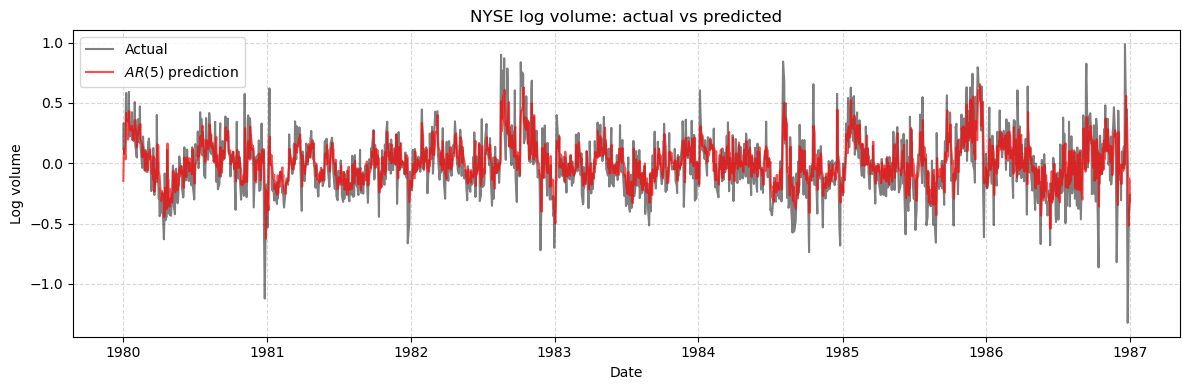

In [12]:
# Evaluate the model:
model.eval()
with torch.no_grad():
    y_test_pred = model(X_test_tensor).cpu().numpy()

r2 = r2_score(y_test, y_test_pred)
print(f"PyTorch linear AR model test R^2: {r2:.4f}")

# Compare predictions:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(test_data.index, y_test, label="Actual", color="black", alpha=0.5)
ax.plot(test_data.index, y_test_pred,
        label="$ AR(5) $ prediction", color="red", alpha=0.7)
ax.set_title("NYSE log volume: actual vs predicted")
ax.set_xlabel("Date")
ax.set_ylabel("Log volume")
ax.legend()
ax.grid(True, linestyle="--", alpha=0.5)
fig.tight_layout()
plt.show()

Running the PyTorch code results in a different $ R^2 $ value each time,
because there are several sources of randomness (random weight initialization,
shuffled data samples for the mini-batches). However, in each run I tried,
the test $ R^2 $ for the PyTorch model ranged from around $ 0.37 $ to $ 0.41 $,
which is slightly worse than the $ 0.41 $ value we obtained in Exercise $ 9 $
(and in the book).

In this particular situation, there is no advantage to using a neural network
model, because there is a closed-form solution to the least squares problem.
What we are considering here is just linear regression, which is a convex
optimization problem with a unique global minimum. This minimum is the $ AR(5)
$ model from Exercise $ 9 $, and is the one the one that scikit-learn obtains,
modulo errors associated with the floating-point system.

In contrast, with PyTorch we use stochastic gradient descent to try
to converge to the global minimum. Moreover, the PyTorch approach requires much
more code, is slower and requires more computational resources. The only benefit
is that we could easily extend our current model to nonlinear models by adding
hidden layers.